# Neural Networks
ANNs are at the very core of Deep Learning. They are versatile, powerful, and
scalable, making them ideal to tackle large and highly complex Machine
Learning tasks

The first part of this chapter introduces artificial neural networks, starting with a
quick tour of the very first ANN architectures and leading up to Multilayer
Perceptrons (MLPs)

## Logical Computations with Neurons

McCulloch and Pitts proposed a very simple model of the biological neuron,
which later became known as an artificial neuron: it has one or more binary
(on/off) inputs and one binary output. The artificial neuron activates its output
when more than a certain number of its inputs are active. In their paper, they
showed that even with such a simplified model it is possible to build a network
of artificial neurons that computes any logical proposition you want. To see how
such a network works, let’s build a few ANNs that perform various logical
computations (see Figure 10-3), assuming that a neuron is activated when at
least two of its inputs are active.

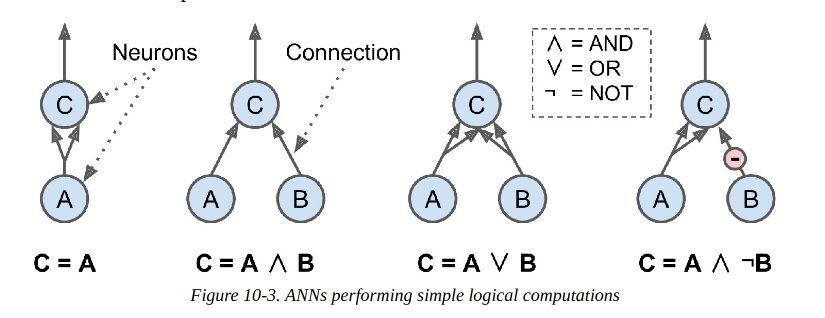

The first network on the left is the identity function: if neuron A is
activated, then neuron C gets activated as well (since it receives two
input signals from neuron A); but if neuron A is off, then neuron C is off as well.

The second network performs a logical AND: neuron C is activated
only when both neurons A and B are activated (a single input signal is
not enough to activate neuron C).

The third network performs a logical OR: neuron C gets activated if
either neuron A or neuron B is activated (or both).

Finally, if we suppose that an input connection can inhibit the neuron’s
activity (which is the case with biological neurons), then the fourth
network computes a slightly more complex logical proposition: neuron
C is activated only if neuron A is active and neuron B is off. If neuron A
is active all the time, then you get a logical NOT: neuron C is active
when neuron B is off, and vice versa.

## The Perceptron

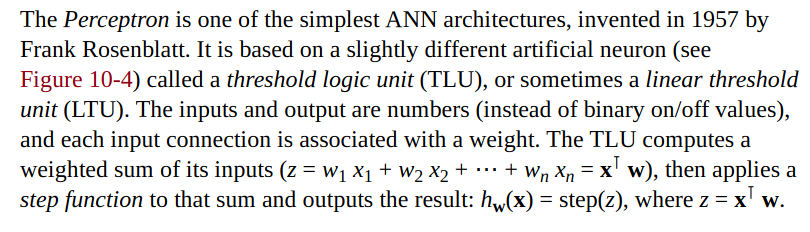
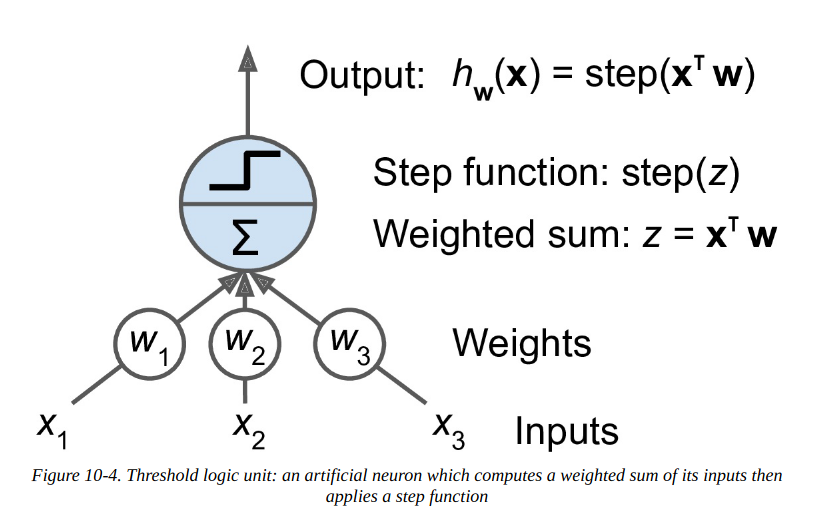

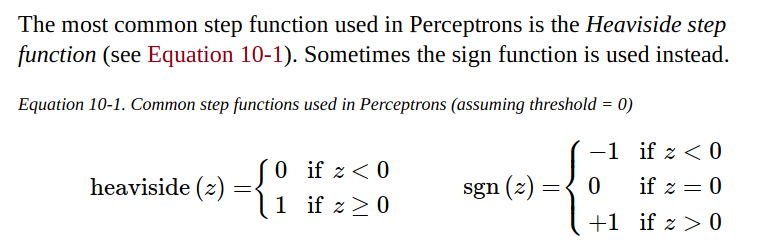

A single TLU can be used for simple linear binary classification. It computes a
linear combination of the inputs, and if the result exceeds a threshold, it outputs
the positive class. Otherwise it outputs the negative class (just like a Logistic
Regression or linear SVM classifier). You could, for example, use a single TLU
to classify iris flowers based on petal length and width (also adding an extra bias
feature x = 1, just like we did in previous chapters). Training a TLU in this case
means finding the right values for w , w , and w (the training algorithm is
discussed shortly).

A Perceptron is simply composed of a single layer of TLUs, with each TLU
connected to all the inputs. When all the neurons in a layer are connected to
every neuron in the previous layer (i.e., its input neurons), the layer is called a
fully connected layer, or a dense layer. The inputs of the Perceptron are fed to
special passthrough neurons called input neurons: they output whatever input
they are fed. All the input neurons form the input layer. Moreover, an extra bias
feature is generally added (x = 1): it is typically represented using a special type
of neuron called a bias neuron, which outputs 1 all the time. A Perceptron with
two inputs and three outputs is represented in Figure 10-5. This Perceptron can
classify instances simultaneously into three different binary classes, which
makes it a multioutput classifier.

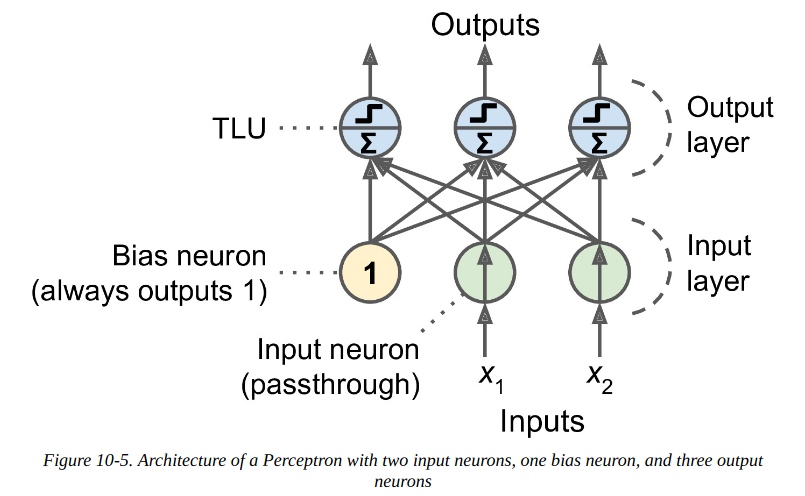

So, how is a Perceptron trained? The Perceptron training algorithm proposed by
Rosenblatt was largely inspired by Hebb’s rule. In his 1949 book The
Organization of Behavior (Wiley), Donald Hebb suggested that when a
biological neuron triggers another neuron often, the connection between these
two neurons grows stronger. Siegrid Löwel later summarized Hebb’s idea in the
catchy phrase, “Cells that fire together, wire together”; that is, the connection
weight between two neurons tends to increase when they fire simultaneously.
This rule later became known as Hebb’s rule (or Hebbian learning). Perceptrons
are trained using a variant of this rule that takes into account the error made by
the network when it makes a prediction; the Perceptron learning rule reinforces
connections that help reduce the error. More specifically, the Perceptron is fed
one training instance at a time, and for each instance it makes its predictions. For
every output neuron that produced a wrong prediction, it reinforces the
connection weights from the inputs that would have contributed to the correct
prediction. The rule is shown in Equation 10-3.

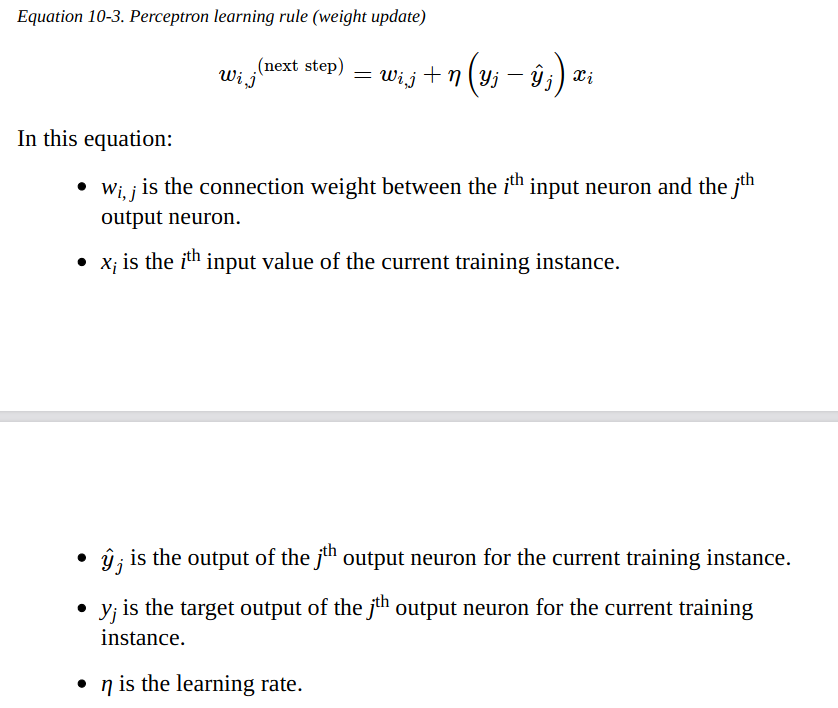

The decision boundary of each output neuron is linear, so Perceptrons are
incapable of learning complex patterns (just like Logistic Regression classifiers).

Scikit-Learn provides a Perceptron class that implements a single-TLU
network. It can be used pretty much as you would expect—for example, on the
iris dataset (introduced in Chapter 4):

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris setosa?
per_clf = Perceptron()
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

/tmp/ipykernel_3848/3311616741.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int) # Iris setosa?


In fact, Scikit-Learn’s Perceptron class is
equivalent to using an SGDClassifier with the following hyperparameters:
loss="perceptron", learning_rate="constant", eta0=1 (the learning rate),
and penalty=None (no regularization).

## The Multilayer Perceptron and Backpropagation

An MLP is composed of one (passthrough) input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer
(see Figure 10-7). The layers close to the input layer are usually called the lower
layers, and the ones close to the outputs are usually called the upper layers.
Every layer except the output layer includes a bias neuron and is fully connected
to the next layer.

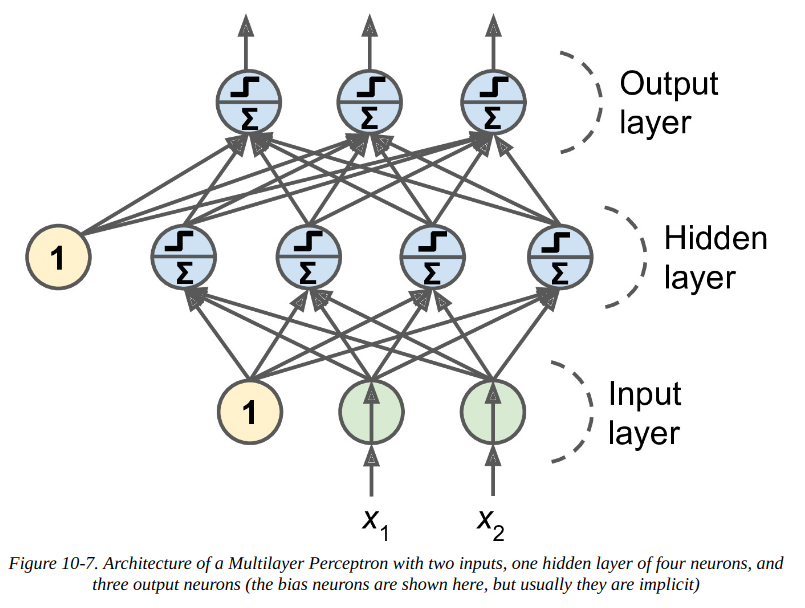

### Note
The signal flows only in one direction (from the inputs to the outputs), so this architecture is an
example of a feedforward neural network (FNN).

When an ANN contains a deep stack of hidden layers, it is called a deep neural
network (DNN). The field of Deep Learning studies DNNs, and more generally
models containing deep stacks of computations. Even so, many people talk about
Deep Learning whenever neural networks are involved (even shallow ones).

### Note
Automatically computing gradients is called automatic differentiation, or autodiff. There are
various autodiff techniques, with different pros and cons. The one used by backpropagation is
called reverse-mode autodiff. It is fast and precise, and is well suited when the function to
differentiate has many variables (e.g., connection weights) and few outputs (e.g., one loss). If
you want to learn more about autodiff, check out Appendix D.

#### Let’s run through this algorithm in a bit more detail:
-   It handles one mini-batch at a time (for example, containing 32
    instances each), and it goes through the full training set multiple times.
    Each pass is called an epoch.

-   Each mini-batch is passed to the network’s input layer, which sends it to
    the first hidden layer. The algorithm then computes the output of all the
    neurons in this layer (for every instance in the mini-batch). The result is
    passed on to the next layer, its output is computed and passed to the
    next layer, and so on until we get the output of the last layer, the output
    layer. This is the forward pass: it is exactly like making predictions,
    except all intermediate results are preserved since they are needed for
    the backward pass.
    
-   Next, the algorithm measures the network’s output error (i.e., it uses a loss function that compares the desired     output and the actual output of
    the network, and returns some measure of the error).
    
-   Then it computes how much each output connection contributed to the
    error. This is done analytically by applying the chain rule (perhaps the
    most fundamental rule in calculus), which makes this step fast and
    precise.
    
-   The algorithm then measures how much of these error contributions
    came from each connection in the layer below, again using the chain
    rule, working backward until the algorithm reaches the input layer. As
    explained earlier, this reverse pass efficiently measures the error
    gradient across all the connection weights in the network by
    propagating the error gradient backward through the network (hence the
    name of the algorithm).
    
-   Finally, the algorithm performs a Gradient Descent step to tweak all the
    connection weights in the network, using the error gradients it just
    computed.

This algorithm is so important that it’s worth summarizing it again: for each
training instance, the backpropagation algorithm first makes a prediction
(forward pass) and measures the error, then goes through each layer in reverse to
measure the error contribution from each connection (reverse pass), and finally
tweaks the connection weights to reduce the error (Gradient Descent step).

### WARNING
It is important to initialize all the hidden layers’ connection weights randomly, or else training
will fail. For example, if you initialize all weights and biases to zero, then all neurons in a
given layer will be perfectly identical, and thus backpropagation will affect them in exactly the
same way, so they will remain identical. In other words, despite having hundreds of neurons
per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If
instead you randomly initialize the weights, you break the symmetry and allow
backpropagation to train a diverse team of neurons.

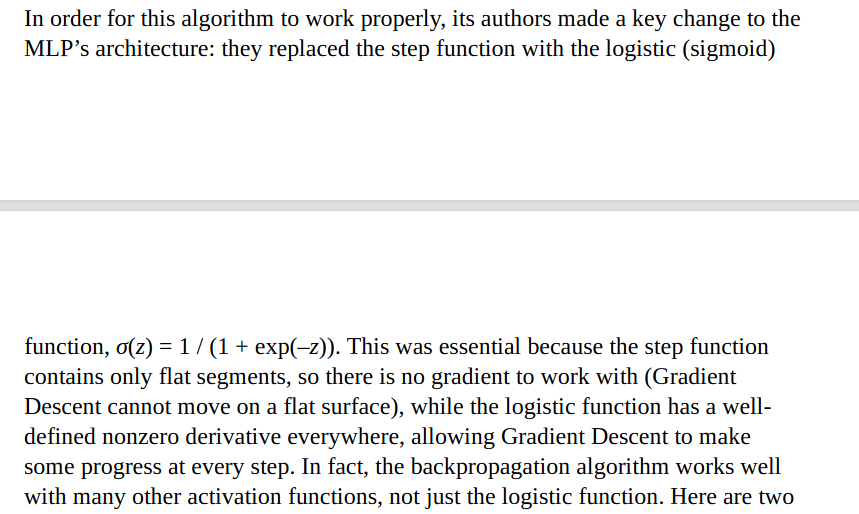

## Regression MLPs

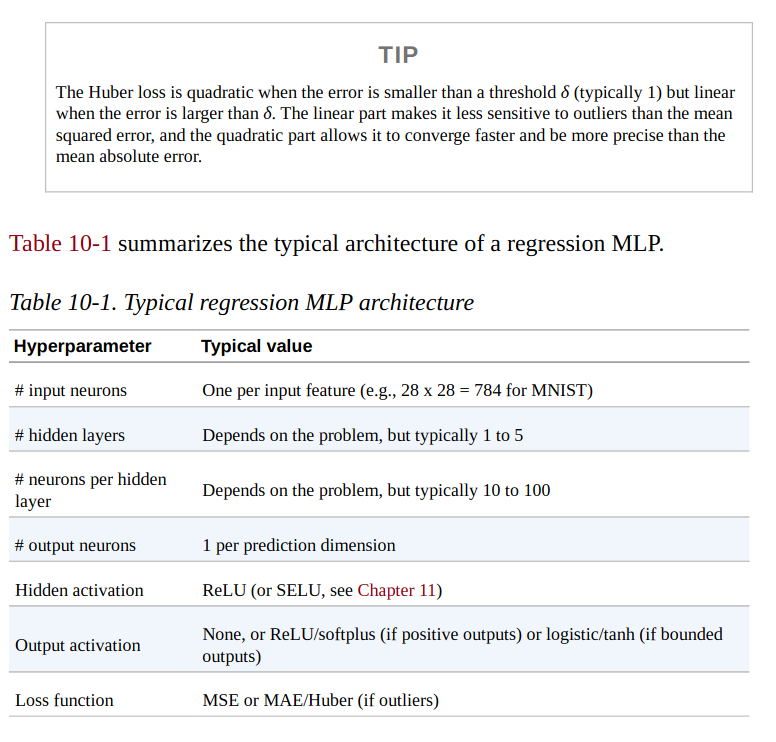

## Classification MLPs 

MLPs can also easily handle multilabel binary classification tasks (see
Chapter 3). For example, you could have an email classification system that
predicts whether each incoming email is ham or spam, and simultaneously
predicts whether it is an urgent or nonurgent email. In this case, you would need
two output neurons, both using the logistic activation function: the first would
output the probability that the email is spam, and the second would output the
probability that it is urgent. More generally, you would dedicate one output
neuron for each positive class. Note that the output probabilities do not
necessarily add up to 1. This lets the model output any combination of labels:
you can have nonurgent ham, urgent ham, nonurgent spam, and perhaps even
urgent spam (although that would probably be an error).
If each instance can belong only to a single class, out of three or more possible
classes (e.g., classes 0 through 9 for digit image classification), then you need to
have one output neuron per class, and you should use the softmax activation
function for the whole output layer (see Figure 10-9). The softmax function
(introduced in Chapter 4) will ensure that all the estimated probabilities are
between 0 and 1 and that they add up to 1 (which is required if the classes are
exclusive). This is called multiclass classification.

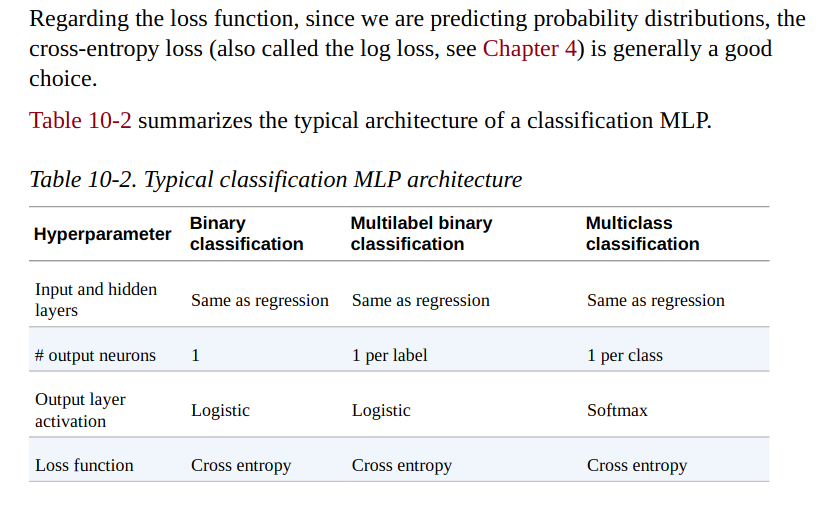

# Implementing MLPs with Keras

## Note
For GPU support, at the time of this writing you need to install tensorflow-gpu instead of
tensorflow, but the TensorFlow team is working on having a single library that will support
both CPU-only and GPU-equipped systems. You will still need to install extra libraries for
GPU support (see https://tensorflow.org/install for more details). We will look at GPUs in
more depth in Chapter 19.

## Building an Image Classifier Using the Sequential API

### Using Keras to load the dataset

THERE IS NO EXECUTIONAL CODE ----> go GoogleColab

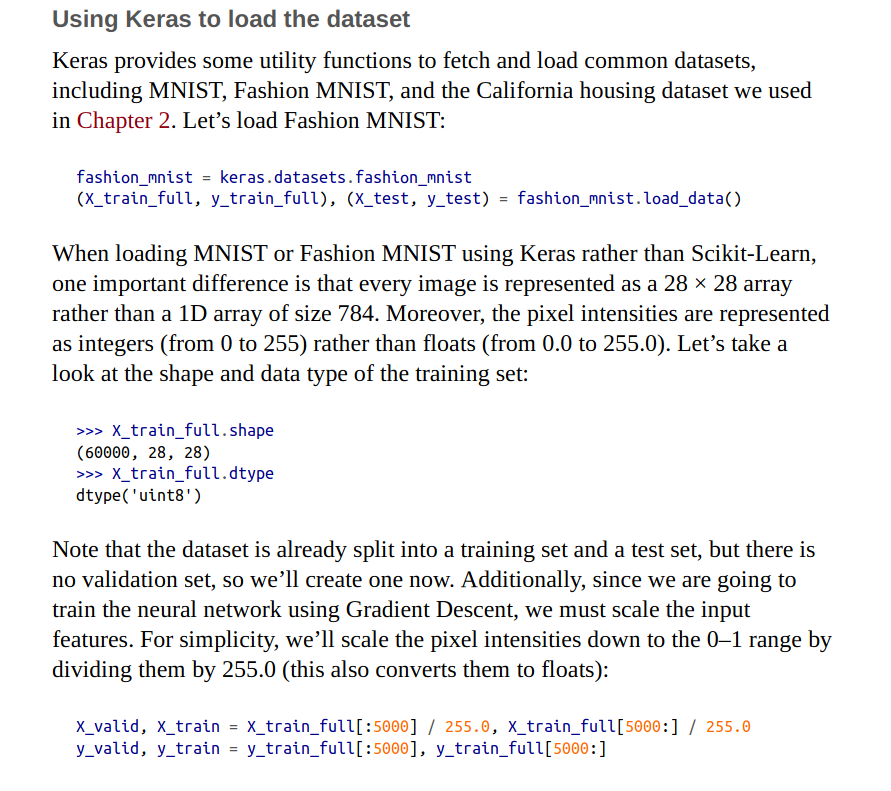

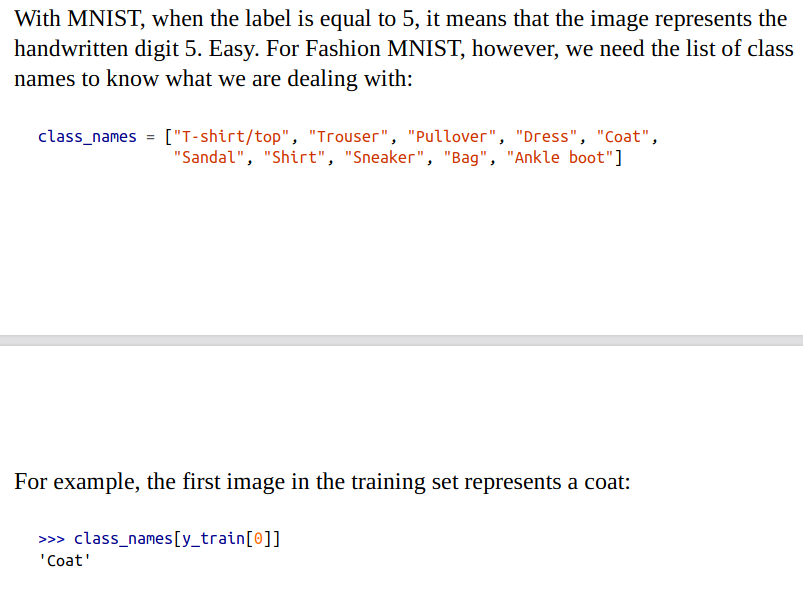

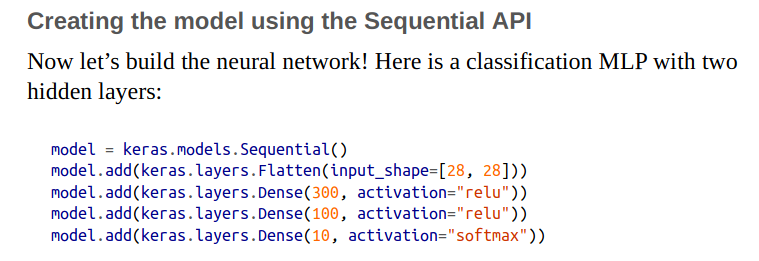

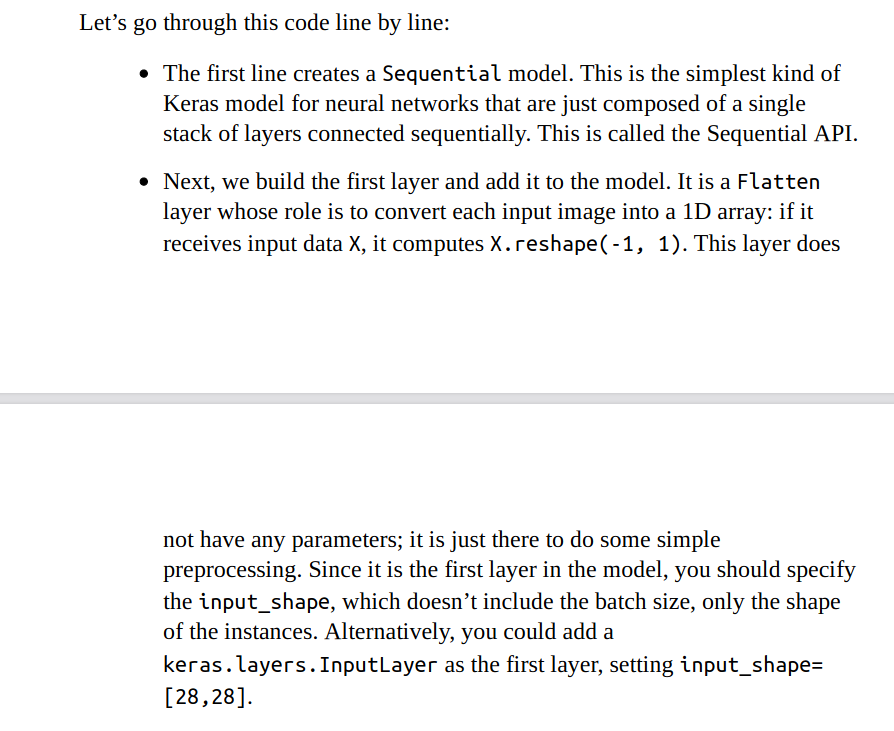
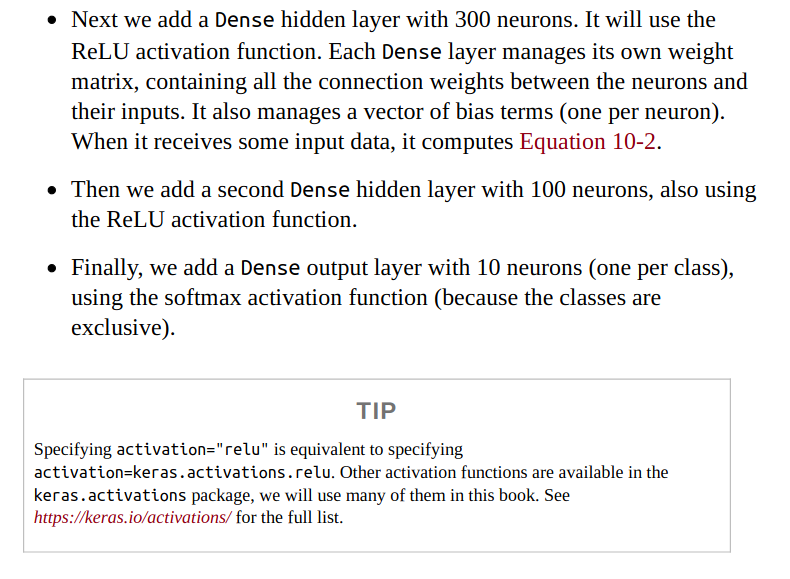

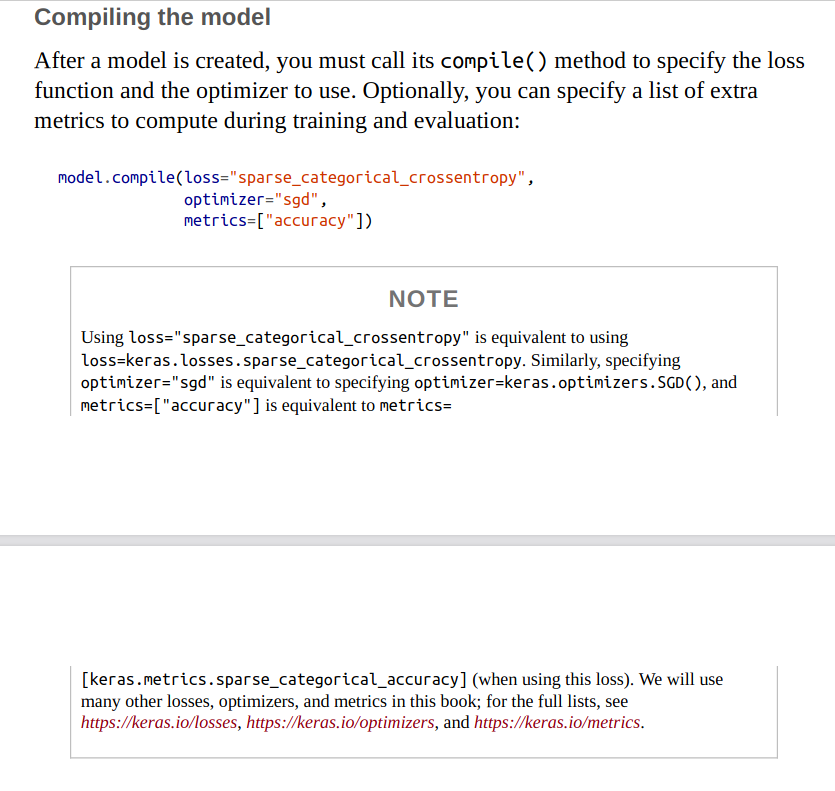
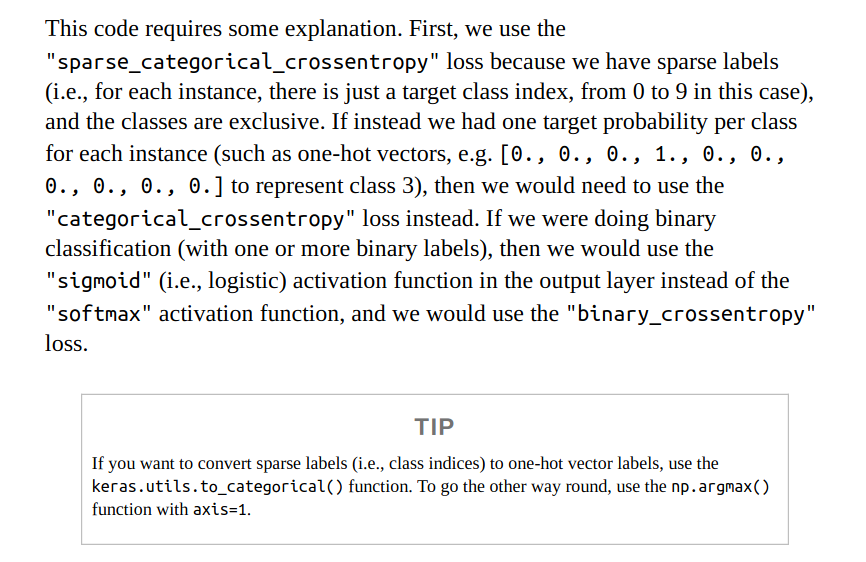
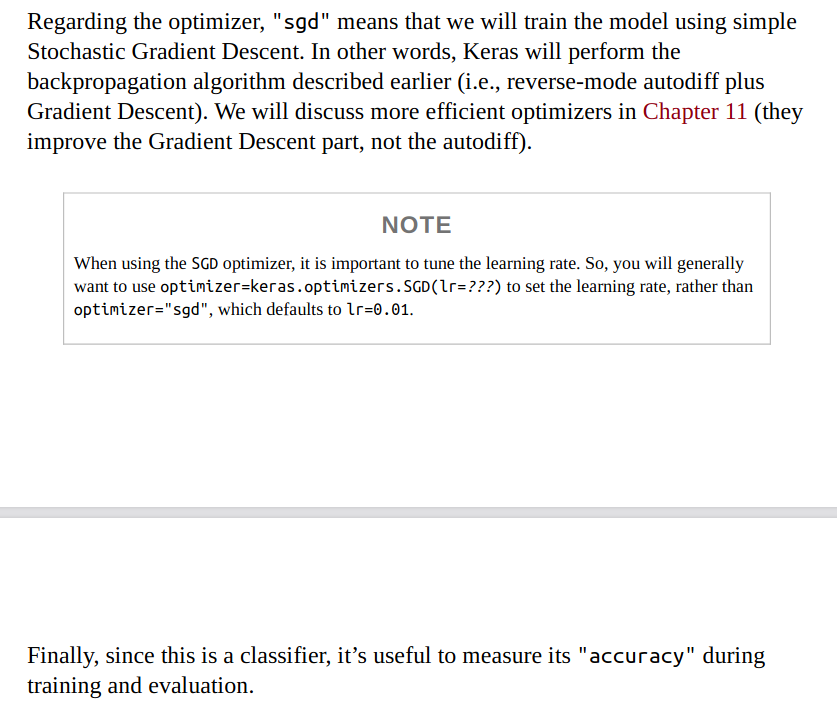

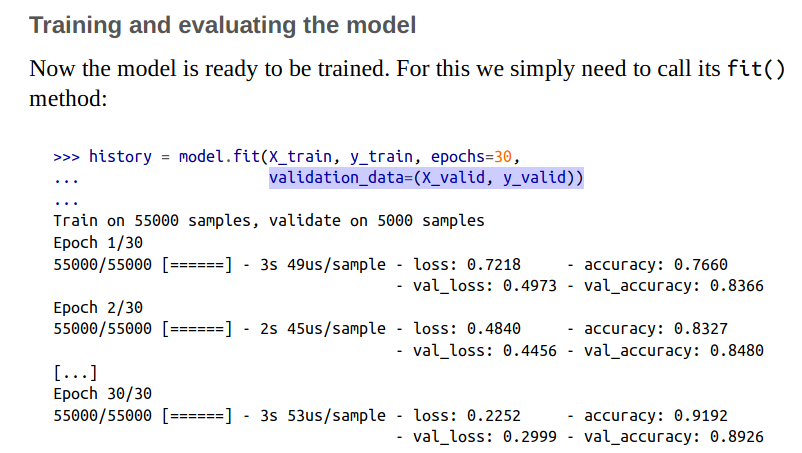

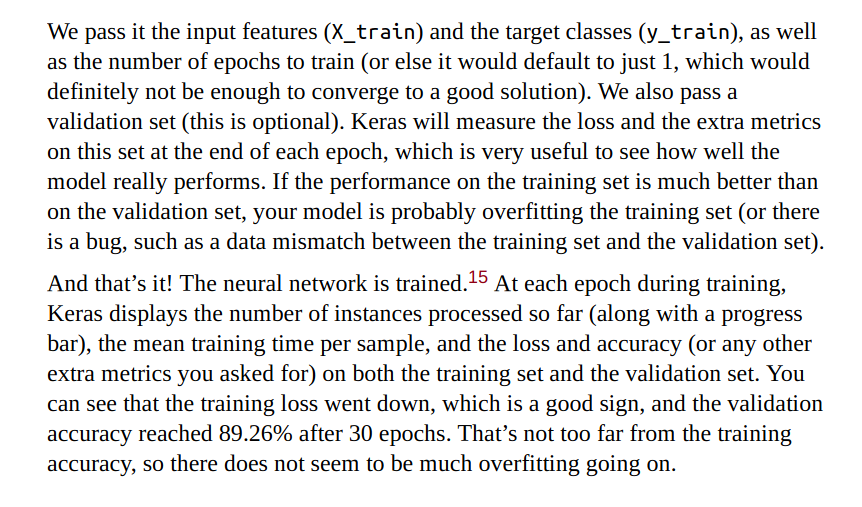